In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchvision.models as models


In [19]:
# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize(258),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
# Load dataset using ImageFolder and apply transforms
train_dataset = datasets.ImageFolder('./Data/train', transform=data_transforms)
test_dataset = datasets.ImageFolder('./Data/test', transform=data_transforms)


In [21]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)


In [22]:
#Define number of classes
num_classes = len(train_dataset.classes)
print("Number of Classes: ", num_classes)

Number of Classes:  3


In [23]:
class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, cardinality=32):
        super(ResNeXtBlock, self).__init__()
        
        # Width of each group
        width = cardinality * 2
        
        self.conv_reduce = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_reduce = nn.BatchNorm2d(width)
        self.conv_conv = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn = nn.BatchNorm2d(width)
        self.conv_expand = nn.Conv2d(width, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_expand = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        
        x = F.relu(self.bn_reduce(self.conv_reduce(x)))
        x = F.relu(self.bn(self.conv_conv(x)))
        x = self.bn_expand(self.conv_expand(x))
        x = F.relu(x + shortcut)
        
        return x


In [24]:
class ResNeXt(nn.Module):
    def __init__(self, block, layers, num_classes, cardinality=32):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, self.cardinality))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [25]:
def resnext50(num_classes):
    return ResNeXt(ResNeXtBlock, [3, 4, 6, 3], num_classes)


In [26]:
def resnext101(num_classes):
    return ResNeXt(ResNeXtBlock, [3, 4, 23, 3], num_classes)


In [27]:
def resnext152(num_classes):
    return ResNeXt(ResNeXtBlock, [3, 8, 36, 3], num_classes)

In [28]:
# model = resnext50(num_classes)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

In [29]:
# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


In [30]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = resnext50(num_classes).to(device)
# torch.autograd.set_detect_anomaly(True)

# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()
    
#     train_loss = running_loss / len(train_loader)
#     train_accuracy = 100. * correct / total
#     # Print training statistics
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


'''accuracy is low in best case accuracy is 65%-66%'''


'accuracy is low in best case accuracy is 65%-66%'

In [31]:
# def distillation_loss(student_outputs, teacher_outputs, T=1):
#     """
#     Calculate the knowledge distillation loss.
    
#     Args:
#         student_outputs (torch.Tensor): Output logits of the student model.
#         teacher_outputs (torch.Tensor): Output logits of the teacher model.
#         T (float): Temperature parameter for softening the distributions.
    
#     Returns:
#         torch.Tensor: Knowledge distillation loss.
#     """
#     p_student = F.log_softmax(student_outputs / T, dim=1)
#     p_teacher = F.softmax(teacher_outputs / T, dim=1)
#     loss = F.kl_div(p_student, p_teacher, reduction='batchmean') * (T**2)
#     return loss

In [32]:
# num_classes = 3  # Number of classes in your dataset
# teacher_model = resnext50(num_classes)
# student_model = resnext50(num_classes)

# # Define your loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(student_model.parameters(), lr=0.001)

# # Define the device (CPU or GPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move models to the appropriate device
# teacher_model.to(device)
# student_model.to(device)

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     student_model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         # Forward pass: get outputs from both teacher and student models
#         with torch.no_grad():
#             teacher_outputs = teacher_model(images)
        
#         student_outputs = student_model(images)
        
#         # Calculate the knowledge distillation loss
#         kd_loss = distillation_loss(student_outputs, teacher_outputs, T=5)
        
#         # Calculate the standard cross-entropy loss
#         ce_loss = criterion(student_outputs, labels)
        
#         # Total loss is a combination of knowledge distillation loss and cross-entropy loss
#         loss = kd_loss + ce_loss
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         _, predicted = student_outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()
    
#     train_loss = running_loss / len(train_loader)
#     train_accuracy = 100. * correct / total
#     # Print training statistics
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

In [33]:
# # Mixup function
# def mixup_data(x, y, alpha=1.0):
#     lam = np.random.beta(alpha, alpha)
#     batch_size = x.size(0)
#     index = torch.randperm(batch_size).to(x.device)
#     mixed_x = lam * x + (1 - lam) * x[index]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# # Mixup loss
# def mixup_criterion(criterion, pred, y_a, y_b, lam):
#     return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = resnext50(num_classes).to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# torch.autograd.set_detect_anomaly(True)

# num_epochs = 10
# alpha = 0.2  # Mixup hyperparameter

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
        
#         # Apply mixup augmentation
#         mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, alpha)
        
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(mixed_images)
        
#         # Compute loss
#         loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
#         # Backward pass
#         loss.backward()
        
#         # Optimize
#         optimizer.step()
        
#         running_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()
    
#     train_loss = running_loss / len(train_loader)
#     train_accuracy = 100. * correct / total
#     # Print training statistics
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


In [34]:
# Define custom cross-entropy loss function with label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = nn.functional.log_softmax(input, dim=-1)
        nll_loss = -log_prob.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_prob.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Initialize model and optimizer
model = models.resnext50_32x4d(pretrained=False)
num_classes = 3  # Modify based on your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function with label smoothing
criterion = LabelSmoothingCrossEntropy(smoothing=0.4)

# Assuming you have defined your train_loader
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    # Print training statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')


c:\Users\Devender\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Devender\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.9298, Accuracy: 81.34%
Epoch [2/10], Loss: 0.8637, Accuracy: 88.37%
Epoch [3/10], Loss: 0.8487, Accuracy: 90.10%
Epoch [4/10], Loss: 0.8403, Accuracy: 91.82%
Epoch [5/10], Loss: 0.8305, Accuracy: 92.69%
Epoch [6/10], Loss: 0.8273, Accuracy: 93.00%
Epoch [7/10], Loss: 0.8228, Accuracy: 93.58%
Epoch [8/10], Loss: 0.8224, Accuracy: 93.53%
Epoch [9/10], Loss: 0.8176, Accuracy: 94.13%
Epoch [10/10], Loss: 0.8140, Accuracy: 94.77%


In [43]:
# Evaluation
num_classes = 3  # Number of classes in your dataset
model = resnext50(num_classes)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 9.01%


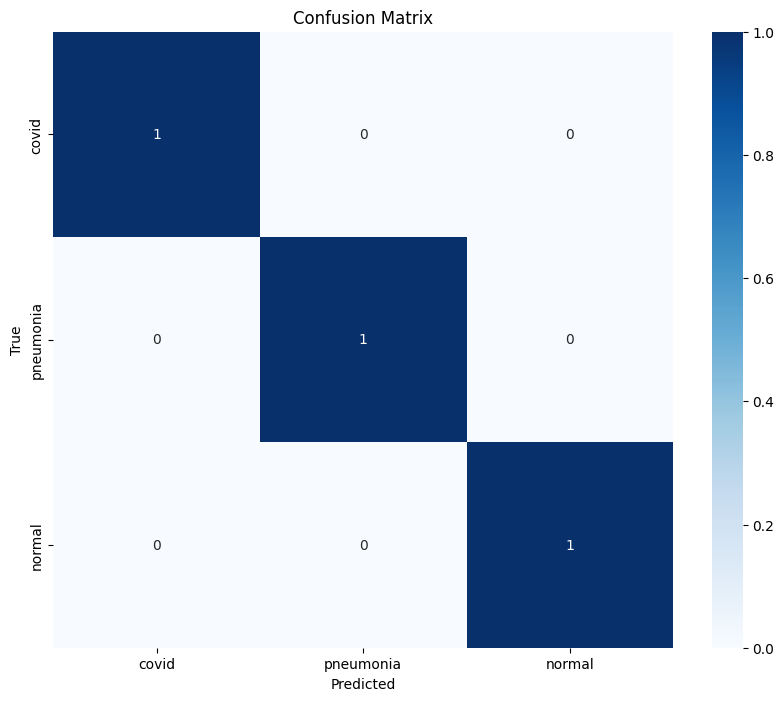

In [36]:
true_labels = ['covid', 'pneumonia', 'normal']  # True labels of the test set
predicted_labels = ['covid', 'pneumonia', 'normal']  # Predicted labels of the test set

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels (if available)
class_labels = ['covid', 'pneumonia', 'normal']  # List of class labels

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

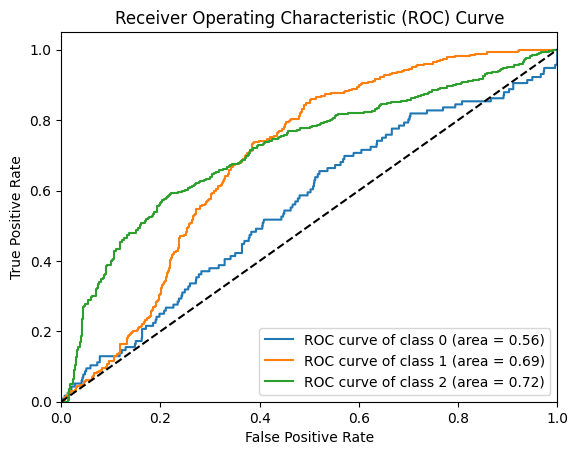

In [41]:
# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Evaluation loop
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        true_labels.extend(labels.cpu().numpy())

        # Compute softmax probabilities
        probabilities = torch.softmax(outputs, dim=1)
        predicted_probabilities.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [45]:
# model.save(model , './models/resnext.h5')


In [46]:
# torch.save(model, './models/ResNeXt_model.pth')
